
# Federated Averaging under Realistic Imperfections (CIFAR-100)

Implementation of synchronous and asynchronous FedAvg for classification of images using CIFAR-100 dataset.

**Course Project:** Optimization for Distributed, Federated, and Asynchronous Systems

This notebook demonstrates:
- Synchronous FedAvg baseline
- Asynchronous FedAvg with arbitrary delays
- IID vs non-IID data partitioning
- Client availability modeling
- Comparative analysis of convergence behavior


## 1. Setup

In [2]:

# Quick start: check environment and seed for reproducibility
import torch, torchvision
print('Torch:', torch.__version__, 'Torchvision:', torchvision.__version__)
print('CUDA available:', torch.cuda.is_available())
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)


Torch: 2.9.0+cu126 Torchvision: 0.24.0+cu126
CUDA available: True


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, Dataset
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, deque
import copy
import random
from typing import List, Dict, Tuple, Optional

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

PyTorch version: 2.9.0+cu126
Device: cuda


In [4]:

# Configuration dictionary - all hyperparameters in one place
config = {
    # Federated setup
    'num_clients': 100,
    'client_fraction': 0.1,  # C: fraction of clients selected per round
    'local_epochs': 5,        # CIFAR-100-specific: more local epochs on A100/GPUs
    'local_batch_size': 128,  # CIFAR-100-specific: larger batch for faster GPU throughput
    'learning_rate': 0.1,     # CIFAR-100-specific: tuned for ResNet on CIFAR
    'momentum': 0.9,          # CIFAR-100-standard SGD momentum
    'weight_decay': 5e-4,     # CIFAR-100-specific: mild regularization
    'num_rounds': 100,

    # Data partitioning
    'num_classes': 100,
    'data_mode': 'iid',  # 'iid', 'dirichlet', or 'label_shard'
    'dirichlet_alpha': 0.5,  # Lower = more heterogeneous (try 0.1, 0.5, 1.0)
    'labels_per_client': 2,  # For label_shard mode

    # Delay and availability
    'delay_mode': 'none',  # 'none', 'uniform', 'exponential'
    'max_delay': 5,  # Maximum delay in rounds
    'p_available': 1.0,  # Client availability probability
    'max_staleness': None,  # None = no bound, otherwise drop updates older than this

    # Eval and logging
    'eval_every': 5,  # Evaluate test accuracy every N rounds
    'seed': 42,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

def set_seed(seed):
    """Set random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(config['seed'])
print("Configuration loaded and seed set.")


Configuration loaded and seed set.



## 2. Data Loading and Partitioning

We implement three partitioning schemes (unchanged from the MNIST version) but now operate on CIFAR-100:

1. **IID**: Random shuffle and equal split - each client gets uniform random samples
2. **Dirichlet**: Sample label proportions from Dir(α) - controls statistical heterogeneity
   - Lower α → more skewed label distributions per client
   - α→∞ approaches IID
3. **Label Shard**: Each client gets examples from only K classes - extreme non-IID


In [5]:

# Download CIFAR-100 (with standard augmentation for train)
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5071, 0.4867, 0.4408),
                         std=(0.2675, 0.2565, 0.2761))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5071, 0.4867, 0.4408),
                         std=(0.2675, 0.2565, 0.2761))
])

train_dataset = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform_train
)

test_dataset = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=transform_test
)

test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Number of classes: {config['num_classes']}")


100%|██████████| 169M/169M [00:05<00:00, 29.0MB/s]


Training samples: 50000
Test samples: 10000
Number of classes: 100


In [6]:

def partition_iid(dataset, num_clients):
    """
    Partition dataset into equal-sized IID shards.

    Returns:
        List of index arrays, one per client
    """
    n_samples = len(dataset)
    indices = np.random.permutation(n_samples)
    shard_size = n_samples // num_clients

    client_indices = []
    for i in range(num_clients):
        start = i * shard_size
        end = start + shard_size if i < num_clients - 1 else n_samples
        client_indices.append(indices[start:end])

    return client_indices


def partition_dirichlet(dataset, num_clients, alpha=0.5):
    """
    Partition using Dirichlet distribution over labels.

    For each client, sample p_k ~ Dir(alpha) giving the proportion of
    each label in that client's dataset. Lower alpha = more heterogeneous.

    Args:
        alpha: Concentration parameter. Lower values (0.1-0.5) create
               highly non-IID partitions, higher values (>1.0) approach IID.
    """
    targets = np.array(dataset.targets)
    n_classes = config.get('num_classes', len(np.unique(targets)))
    n_samples = len(targets)

    # Group indices by label
    label_indices = {k: np.where(targets == k)[0] for k in range(n_classes)}

    client_indices = [[] for _ in range(num_clients)]

    # For each class, split its samples among clients according to Dirichlet
    for k in range(n_classes):
        idx_k = label_indices[k]
        np.random.shuffle(idx_k)

        # Sample proportions from Dirichlet
        proportions = np.random.dirichlet(np.repeat(alpha, num_clients))
        # Balance: make proportions sum to number of samples
        proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]

        # Split indices according to proportions
        splits = np.split(idx_k, proportions)
        for client_id, split in enumerate(splits):
            client_indices[client_id].extend(split)

    # Shuffle each client's data
    for i in range(num_clients):
        np.random.shuffle(client_indices[i])
        client_indices[i] = np.array(client_indices[i])

    return client_indices


def partition_label_shard(dataset, num_clients, labels_per_client=2):
    """
    Each client gets examples from only K labels (pathological non-IID).

    This is an extreme form of heterogeneity where label distributions
    don't overlap much between clients.
    """
    targets = np.array(dataset.targets)
    n_classes = config.get('num_classes', len(np.unique(targets)))

    # Group indices by label
    label_indices = {k: np.where(targets == k)[0] for k in range(n_classes)}
    for k in label_indices:
        np.random.shuffle(label_indices[k])

    client_indices = []

    # Assign labels to clients (with possible overlap)
    label_assignments = []
    for i in range(num_clients):
        assigned_labels = np.random.choice(n_classes, labels_per_client, replace=False)
        label_assignments.append(assigned_labels)

    # Distribute samples for each label among clients that have it
    label_cursors = {k: 0 for k in range(n_classes)}
    samples_per_label = max(1, len(dataset) // (num_clients * labels_per_client))

    for client_id in range(num_clients):
        client_data = []

        for label in label_assignments[client_id]:
            start = label_cursors[label]
            end = min(start + samples_per_label, len(label_indices[label]))
            client_data.extend(label_indices[label][start:end])
            label_cursors[label] = end

        np.random.shuffle(client_data)
        client_indices.append(np.array(client_data))

    return client_indices


def create_client_datasets(cfg, dataset):
    """
    Main entry point for data partitioning.

    Returns:
        List of Subset objects, one per client
    """
    mode = cfg['data_mode']
    num_clients = cfg['num_clients']

    if mode == 'iid':
        indices_list = partition_iid(dataset, num_clients)
    elif mode == 'dirichlet':
        indices_list = partition_dirichlet(dataset, num_clients, cfg['dirichlet_alpha'])
    elif mode == 'label_shard':
        indices_list = partition_label_shard(dataset, num_clients, cfg['labels_per_client'])
    else:
        raise ValueError(f"Unknown data_mode: {mode}")

    client_datasets = [Subset(dataset, indices) for indices in indices_list]

    # Print statistics
    sizes = [len(ds) for ds in client_datasets]
    print(f"Partitioning mode: {mode}")
    print(f"Client dataset sizes - min: {min(sizes)}, max: {max(sizes)}, mean: {np.mean(sizes):.1f}")

    return client_datasets


Partitioning mode: iid
Client dataset sizes - min: 500, max: 500, mean: 500.0


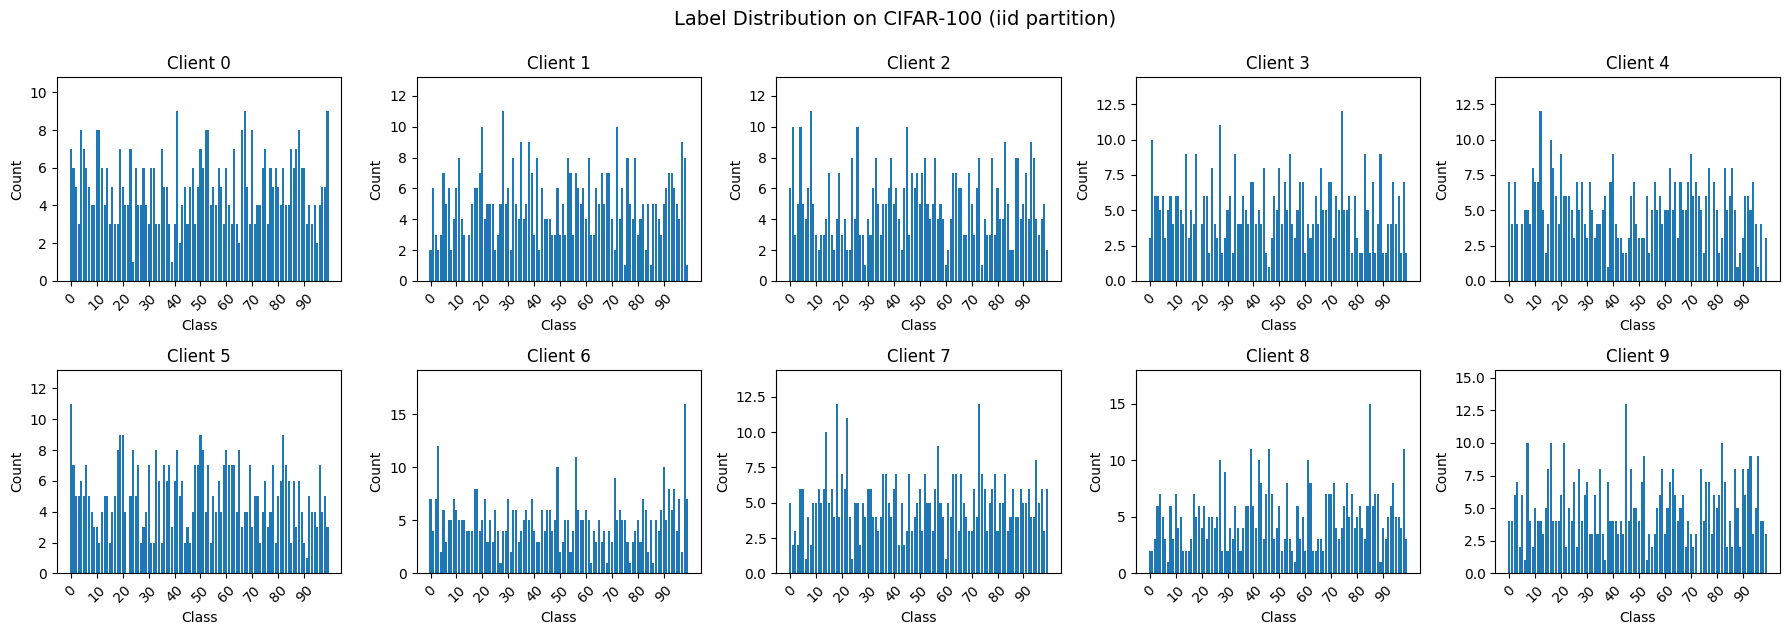

In [7]:

# Create partitions for current config
client_datasets = create_client_datasets(config, train_dataset)

# Visualize label distribution for first few clients
def plot_label_distribution(client_datasets, num_clients_to_plot=10):
    fig, axes = plt.subplots(2, 5, figsize=(18, 6))
    axes = axes.flatten()
    num_classes = config.get('num_classes', 100)
    targets_array = np.array(train_dataset.targets)

    for i in range(min(num_clients_to_plot, len(client_datasets))):
        targets = targets_array[client_datasets[i].indices]
        label_counts = np.bincount(targets, minlength=num_classes)

        axes[i].bar(range(num_classes), label_counts)
        axes[i].set_title(f'Client {i}')
        axes[i].set_xlabel('Class')
        axes[i].set_ylabel('Count')
        axes[i].set_ylim([0, max(label_counts) * 1.2 if label_counts.max() > 0 else 1])
        axes[i].set_xticks(range(0, num_classes, max(1, num_classes // 10)))
        axes[i].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.suptitle(f"Label Distribution on CIFAR-100 ({config['data_mode']} partition)", y=1.05, fontsize=14)
    plt.show()

plot_label_distribution(client_datasets)



## 3. Model Definition

Deeper CNN architecture for CIFAR-100 (32x32 RGB) with batch normalization and dropout.


In [8]:

class CIFAR100Net(nn.Module):
    def __init__(self, num_classes=100):
        super(CIFAR100Net, self).__init__()
        # Start from torchvision ResNet-18 but adapt for 32x32 inputs
        self.model = torchvision.models.resnet18(weights=None)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.maxpool = nn.Identity()
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)


def create_model(num_classes=None):
    """Factory function to create a fresh model instance."""
    num_classes = num_classes or config.get('num_classes', 100)
    return CIFAR100Net(num_classes=num_classes)


def get_model_params(model):
    """
    Extract model parameters as a state dict.
    Returns a deep copy to avoid aliasing issues.
    """
    return copy.deepcopy(model.state_dict())


def set_model_params(model, params):
    """
    Load parameters into a model.
    """
    model.load_state_dict(params)


def average_models(params_list, weights):
    """
    Weighted average of model parameters.

    Args:
        params_list: List of state dicts
        weights: List of weights (e.g., num samples per client)

    Returns:
        Averaged state dict
    """
    if len(params_list) == 0:
        return None

    # Normalize weights
    weights = np.array(weights, dtype=np.float32)
    weights /= weights.sum()

    avg_params = copy.deepcopy(params_list[0])

    for key in avg_params.keys():
        # Start with zeros
        avg_params[key] = torch.zeros_like(avg_params[key], dtype=torch.float32)

        # Weighted sum
        for i, params in enumerate(params_list):
            avg_params[key] += weights[i] * params[key].float()

    return avg_params


# Test model creation
test_model = create_model()
print(f"Model architecture:")
print(test_model)
print(f"Total parameters: {sum(p.numel() for p in test_model.parameters())}")


Model architecture:
CIFAR100Net(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inpl


## 4. Synchronous FedAvg Baseline

Standard FedAvg algorithm on CIFAR-100:
1. Server broadcasts global model to selected clients
2. Clients train locally for E epochs
3. Server aggregates client updates via weighted averaging
4. Repeat for T rounds


In [9]:

class Client:
    def __init__(self, client_id, dataset, cfg):
        self.client_id = client_id
        self.dataset = dataset
        self.cfg = cfg
        self.dataloader = DataLoader(
            dataset,
            batch_size=cfg['local_batch_size'],
            shuffle=True
        )

    def local_update(self, global_params):
        """
        Perform local training for E epochs on client's data.

        Args:
            global_params: Current global model parameters

        Returns:
            Updated model parameters and training loss
        """
        model = create_model().to(self.cfg['device'])
        set_model_params(model, global_params)
        model.train()

        optimizer = torch.optim.SGD(
            model.parameters(),
            lr=self.cfg['learning_rate'],
            momentum=self.cfg.get('momentum', 0.0),
            weight_decay=self.cfg.get('weight_decay', 0.0)
        )
        criterion = nn.CrossEntropyLoss()

        epoch_losses = []

        for epoch in range(self.cfg['local_epochs']):
            batch_losses = []
            for data, target in self.dataloader:
                data, target = data.to(self.cfg['device']), target.to(self.cfg['device'])

                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                batch_losses.append(loss.item())

            epoch_losses.append(np.mean(batch_losses))

        updated_params = get_model_params(model)
        avg_loss = np.mean(epoch_losses)

        return updated_params, avg_loss

    def get_num_samples(self):
        return len(self.dataset)


In [10]:

def evaluate_model(params, test_loader, device):
    """
    Evaluate model on test set.

    Returns:
        accuracy, loss
    """
    model = create_model().to(device)
    set_model_params(model, params)
    model.eval()

    criterion = nn.CrossEntropyLoss()
    correct = 0
    total = 0
    total_loss = 0.0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            total_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100.0 * correct / total
    avg_loss = total_loss / total

    return accuracy, avg_loss


In [11]:
def server_round_sync(global_params, clients, cfg):
    """
    Execute one round of synchronous FedAvg.

    Args:
        global_params: Current global model parameters
        clients: List of all clients
        cfg: Configuration dict

    Returns:
        Updated global parameters
    """
    # Sample clients for this round
    num_selected = max(1, int(cfg['client_fraction'] * len(clients)))
    selected_clients = np.random.choice(clients, num_selected, replace=False)

    # Collect updates from selected clients
    client_params = []
    client_weights = []

    for client in selected_clients:
        params, loss = client.local_update(global_params)
        client_params.append(params)
        client_weights.append(client.get_num_samples())

    # Aggregate via weighted averaging
    new_global_params = average_models(client_params, client_weights)

    return new_global_params

In [12]:

def run_fedavg_sync(cfg, client_datasets, test_loader):
    """
    Main training loop for synchronous FedAvg.

    Returns:
        Dictionary with training history
    """
    # Initialize clients
    clients = [
        Client(i, client_datasets[i], cfg)
        for i in range(cfg['num_clients'])
    ]

    # Initialize global model
    global_model = create_model()
    global_params = get_model_params(global_model)

    # Tracking metrics
    history = {
        'rounds': [],
        'test_acc': [],
        'test_loss': []
    }

    print("Starting synchronous FedAvg training on CIFAR-100...")
    print(f"Total clients: {cfg['num_clients']}, Selected per round: {int(cfg['client_fraction'] * cfg['num_clients'])}")

    for round_idx in range(cfg['num_rounds']):
        # Execute one round
        global_params = server_round_sync(global_params, clients, cfg)

        # Evaluate periodically
        if (round_idx + 1) % cfg['eval_every'] == 0 or round_idx == 0:
            acc, loss = evaluate_model(global_params, test_loader, cfg['device'])
            history['rounds'].append(round_idx + 1)
            history['test_acc'].append(acc)
            history['test_loss'].append(loss)

            print(f"Round {round_idx+1:3d}: Test Accuracy = {acc:.2f}%, Test Loss = {loss:.4f}")

    print("Training complete!")
    return history



## 5. Asynchronous / Delayed FedAvg

Simulate realistic system imperfections on CIFAR-100:
- **Variable delays**: Client updates arrive after random delays (network latency, computation time)
- **Client availability**: Not all clients are available in every round
- **Staleness**: Updates computed on old global parameters

Key difference from sync: Server maintains a queue of pending updates and applies them as they arrive.


In [13]:
def sample_delay(cfg):
    """
    Sample a delay (in rounds) for a client update.

    Returns:
        Integer delay >= 0
    """
    mode = cfg['delay_mode']

    if mode == 'none':
        return 0
    elif mode == 'uniform':
        return np.random.randint(0, cfg['max_delay'] + 1)
    elif mode == 'exponential':
        # Sample from exponential and clip to max_delay
        delay = int(np.random.exponential(cfg['max_delay'] / 2))
        return min(delay, cfg['max_delay'])
    else:
        raise ValueError(f"Unknown delay_mode: {mode}")


class AsyncUpdate:
    """Represents a pending asynchronous update."""
    def __init__(self, client_id, params, arrival_round, compute_round, num_samples):
        self.client_id = client_id
        self.params = params
        self.arrival_round = arrival_round
        self.compute_round = compute_round  # when it was computed
        self.num_samples = num_samples

    def get_staleness(self, current_round):
        """Staleness = delay between computation and application."""
        return current_round - self.compute_round

In [14]:

def run_fedavg_async(cfg, client_datasets, test_loader):
    """
    Asynchronous FedAvg with delays and client availability.

    At each round:
    1. Apply all updates that have arrived (aggregate them)
    2. Select available clients and schedule their updates with delays
    3. Evaluate and log metrics

    Returns:
        Dictionary with training history including staleness stats
    """
    # Initialize clients
    clients = [
        Client(i, client_datasets[i], cfg)
        for i in range(cfg['num_clients'])
    ]

    # Initialize global model
    global_model = create_model()
    global_params = get_model_params(global_model)

    # Queue of pending updates, organized by arrival round
    pending_updates = defaultdict(list)  # arrival_round -> list of AsyncUpdate

    # Tracking metrics
    history = {
        'rounds': [],
        'test_acc': [],
        'test_loss': [],
        'staleness': [],  # staleness of each applied update
        'num_updates_per_round': []  # how many updates applied per round
    }

    print("Starting asynchronous FedAvg training on CIFAR-100...")
    print(f"Delay mode: {cfg['delay_mode']}, Max delay: {cfg['max_delay']}")
    print(f"Client availability: {cfg['p_available']}")

    for round_idx in range(cfg['num_rounds']):
        current_round = round_idx + 1

        # Step 1: Apply arriving updates
        if current_round in pending_updates:
            arriving = pending_updates[current_round]

            # Filter out stale updates if max_staleness is set
            if cfg['max_staleness'] is not None:
                arriving = [
                    upd for upd in arriving
                    if upd.get_staleness(current_round) <= cfg['max_staleness']
                ]

            if len(arriving) > 0:
                # Aggregate all arriving updates
                params_list = [upd.params for upd in arriving]
                weights_list = [upd.num_samples for upd in arriving]

                # Track staleness
                for upd in arriving:
                    history['staleness'].append(upd.get_staleness(current_round))

                # Update global parameters
                aggregated = average_models(params_list, weights_list)
                global_params = aggregated

            history['num_updates_per_round'].append(len(arriving))
            del pending_updates[current_round]
        else:
            history['num_updates_per_round'].append(0)

        # Step 2: Select and schedule new client updates
        # First determine which clients are available
        available_mask = np.random.rand(len(clients)) < cfg['p_available']
        available_clients = [c for i, c in enumerate(clients) if available_mask[i]]

        if len(available_clients) > 0:
            # Sample from available clients
            num_selected = max(1, int(cfg['client_fraction'] * len(clients)))
            num_selected = min(num_selected, len(available_clients))
            selected = np.random.choice(available_clients, num_selected, replace=False)

            for client in selected:
                # Client computes update based on current global params
                params, loss = client.local_update(global_params)

                # Sample delay
                delay = sample_delay(cfg)
                arrival_round = current_round + delay

                # Schedule update
                update = AsyncUpdate(
                    client_id=client.client_id,
                    params=params,
                    arrival_round=arrival_round,
                    compute_round=current_round,
                    num_samples=client.get_num_samples()
                )
                pending_updates[arrival_round].append(update)

        # Step 3: Evaluate periodically
        if current_round % cfg['eval_every'] == 0 or current_round == 1:
            acc, loss = evaluate_model(global_params, test_loader, cfg['device'])
            history['rounds'].append(current_round)
            history['test_acc'].append(acc)
            history['test_loss'].append(loss)

            avg_staleness = np.mean(history['staleness']) if len(history['staleness']) > 0 else 0
            print(f"Round {current_round:3d}: Test Acc = {acc:.2f}%, "
                  f"Avg Staleness = {avg_staleness:.2f}")

    print("Training complete!")

    # Summary statistics
    if len(history['staleness']) > 0:
        print(f"Staleness statistics:")
        print(f"  Mean: {np.mean(history['staleness']):.2f}")
        print(f"  Max: {np.max(history['staleness'])}")
        print(f"  Median: {np.median(history['staleness']):.2f}")

    return history



## 6. Experiments and Visualization

We'll run the same suite of experiments on CIFAR-100 to understand how non-IID data and delays affect convergence.


In [15]:

# Experiment 1: Synchronous baseline with IID data (CIFAR-100)
print("=" * 60)
print("Experiment 1: Sync FedAvg with IID data on CIFAR-100")
print("=" * 60)

config_sync_iid = config.copy()
config_sync_iid['data_mode'] = 'iid'
config_sync_iid['delay_mode'] = 'none'
set_seed(config['seed'])

client_datasets_iid = create_client_datasets(config_sync_iid, train_dataset)
history_sync_iid = run_fedavg_sync(config_sync_iid, client_datasets_iid, test_loader)


Experiment 1: Sync FedAvg with IID data on CIFAR-100
Partitioning mode: iid
Client dataset sizes - min: 500, max: 500, mean: 500.0
Starting synchronous FedAvg training on CIFAR-100...
Total clients: 100, Selected per round: 10
Round   1: Test Accuracy = 1.99%, Test Loss = 4.7178
Round   5: Test Accuracy = 14.97%, Test Loss = 3.7181
Round  10: Test Accuracy = 22.99%, Test Loss = 3.2785
Round  15: Test Accuracy = 28.61%, Test Loss = 3.0033
Round  20: Test Accuracy = 33.52%, Test Loss = 2.7566
Round  25: Test Accuracy = 36.76%, Test Loss = 2.5970
Round  30: Test Accuracy = 40.25%, Test Loss = 2.4429
Round  35: Test Accuracy = 42.73%, Test Loss = 2.3223
Round  40: Test Accuracy = 45.01%, Test Loss = 2.1798
Round  45: Test Accuracy = 46.53%, Test Loss = 2.1427
Round  50: Test Accuracy = 48.33%, Test Loss = 2.1027
Round  55: Test Accuracy = 49.07%, Test Loss = 2.0409
Round  60: Test Accuracy = 51.38%, Test Loss = 1.9447
Round  65: Test Accuracy = 50.80%, Test Loss = 2.0028
Round  70: Test Ac

In [16]:

# Experiment 2: Synchronous with non-IID data (Dirichlet)
print("=" * 60)
print("Experiment 2: Sync FedAvg with non-IID data (Dirichlet α=0.5) on CIFAR-100")
print("=" * 60)

config_sync_noniid = config.copy()
config_sync_noniid['data_mode'] = 'dirichlet'
config_sync_noniid['dirichlet_alpha'] = 0.5
config_sync_noniid['delay_mode'] = 'none'
set_seed(config['seed'])

client_datasets_noniid = create_client_datasets(config_sync_noniid, train_dataset)
history_sync_noniid = run_fedavg_sync(config_sync_noniid, client_datasets_noniid, test_loader)


Experiment 2: Sync FedAvg with non-IID data (Dirichlet α=0.5) on CIFAR-100
Partitioning mode: dirichlet
Client dataset sizes - min: 322, max: 658, mean: 500.0
Starting synchronous FedAvg training on CIFAR-100...
Total clients: 100, Selected per round: 10
Round   1: Test Accuracy = 1.00%, Test Loss = 4.6574
Round   5: Test Accuracy = 3.83%, Test Loss = 4.3780
Round  10: Test Accuracy = 4.17%, Test Loss = 4.3204
Round  15: Test Accuracy = 9.14%, Test Loss = 3.8756
Round  20: Test Accuracy = 13.76%, Test Loss = 3.6388
Round  25: Test Accuracy = 17.77%, Test Loss = 3.3871
Round  30: Test Accuracy = 19.95%, Test Loss = 3.2662
Round  35: Test Accuracy = 24.78%, Test Loss = 3.0278
Round  40: Test Accuracy = 23.39%, Test Loss = 3.0793
Round  45: Test Accuracy = 25.21%, Test Loss = 2.9919
Round  50: Test Accuracy = 31.37%, Test Loss = 2.7096
Round  55: Test Accuracy = 34.31%, Test Loss = 2.5800
Round  60: Test Accuracy = 32.99%, Test Loss = 2.6540
Round  65: Test Accuracy = 20.81%, Test Loss = 

In [17]:

# Experiment 3: Async with IID data and moderate delays
print("=" * 60)
print("Experiment 3: Async FedAvg with IID data and delays on CIFAR-100")
print("=" * 60)

config_async_iid = config.copy()
config_async_iid['data_mode'] = 'iid'
config_async_iid['delay_mode'] = 'uniform'
config_async_iid['max_delay'] = 5
config_async_iid['p_available'] = 0.8  # 80% availability
set_seed(config['seed'])

client_datasets_iid_2 = create_client_datasets(config_async_iid, train_dataset)
history_async_iid = run_fedavg_async(config_async_iid, client_datasets_iid_2, test_loader)


Experiment 3: Async FedAvg with IID data and delays on CIFAR-100
Partitioning mode: iid
Client dataset sizes - min: 500, max: 500, mean: 500.0
Starting asynchronous FedAvg training on CIFAR-100...
Delay mode: uniform, Max delay: 5
Client availability: 0.8
Round   1: Test Acc = 1.00%, Avg Staleness = 0.00
Round   5: Test Acc = 5.15%, Avg Staleness = 2.17
Round  10: Test Acc = 11.50%, Avg Staleness = 3.08
Round  15: Test Acc = 14.73%, Avg Staleness = 3.10
Round  20: Test Acc = 17.21%, Avg Staleness = 3.11
Round  25: Test Acc = 20.74%, Avg Staleness = 3.07
Round  30: Test Acc = 23.28%, Avg Staleness = 2.98
Round  35: Test Acc = 24.49%, Avg Staleness = 2.97
Round  40: Test Acc = 27.53%, Avg Staleness = 2.96
Round  45: Test Acc = 26.57%, Avg Staleness = 2.94
Round  50: Test Acc = 30.01%, Avg Staleness = 2.94
Round  55: Test Acc = 26.11%, Avg Staleness = 2.94
Round  60: Test Acc = 34.72%, Avg Staleness = 2.92
Round  65: Test Acc = 32.28%, Avg Staleness = 2.94
Round  70: Test Acc = 37.03%, Av

In [18]:

# Experiment 4: Async with non-IID data and moderate delays
print("=" * 60)
print("Experiment 4: Async FedAvg with non-IID data and delays on CIFAR-100")
print("=" * 60)

config_async_noniid = config.copy()
config_async_noniid['data_mode'] = 'dirichlet'
config_async_noniid['dirichlet_alpha'] = 0.5
config_async_noniid['delay_mode'] = 'uniform'
config_async_noniid['max_delay'] = 5
config_async_noniid['p_available'] = 0.8
set_seed(config['seed'])

client_datasets_noniid_2 = create_client_datasets(config_async_noniid, train_dataset)
history_async_noniid = run_fedavg_async(config_async_noniid, client_datasets_noniid_2, test_loader)


Experiment 4: Async FedAvg with non-IID data and delays on CIFAR-100
Partitioning mode: dirichlet
Client dataset sizes - min: 322, max: 658, mean: 500.0
Starting asynchronous FedAvg training on CIFAR-100...
Delay mode: uniform, Max delay: 5
Client availability: 0.8
Round   1: Test Acc = 1.00%, Avg Staleness = 0.00
Round   5: Test Acc = 1.00%, Avg Staleness = 2.06
Round  10: Test Acc = 1.55%, Avg Staleness = 2.76
Round  15: Test Acc = 2.92%, Avg Staleness = 2.86
Round  20: Test Acc = 2.85%, Avg Staleness = 2.88
Round  25: Test Acc = 1.84%, Avg Staleness = 2.95
Round  30: Test Acc = 2.92%, Avg Staleness = 2.84
Round  35: Test Acc = 5.91%, Avg Staleness = 2.85
Round  40: Test Acc = 7.96%, Avg Staleness = 2.90
Round  45: Test Acc = 10.73%, Avg Staleness = 2.92
Round  50: Test Acc = 11.53%, Avg Staleness = 2.91
Round  55: Test Acc = 3.57%, Avg Staleness = 2.90
Round  60: Test Acc = 2.11%, Avg Staleness = 2.92
Round  65: Test Acc = 11.14%, Avg Staleness = 2.95
Round  70: Test Acc = 18.05%, A

In [19]:

# Experiment 5: Async with non-IID and heavy delays (stress test)
print("" + "=" * 60)
print("Experiment 5: Async FedAvg with non-IID and heavy delays on CIFAR-100")
print("=" * 60)

config_async_heavy = config.copy()
config_async_heavy['data_mode'] = 'dirichlet'
config_async_heavy['dirichlet_alpha'] = 0.3  # More heterogeneous
config_async_heavy['delay_mode'] = 'uniform'
config_async_heavy['max_delay'] = 15
config_async_heavy['p_available'] = 0.6  # Lower availability
set_seed(config['seed'])

client_datasets_heavy = create_client_datasets(config_async_heavy, train_dataset)
history_async_heavy = run_fedavg_async(config_async_heavy, client_datasets_heavy, test_loader)


Experiment 5: Async FedAvg with non-IID and heavy delays on CIFAR-100
Partitioning mode: dirichlet
Client dataset sizes - min: 338, max: 749, mean: 500.0
Starting asynchronous FedAvg training on CIFAR-100...
Delay mode: uniform, Max delay: 15
Client availability: 0.6
Round   1: Test Acc = 1.00%, Avg Staleness = 0.00
Round   5: Test Acc = 1.00%, Avg Staleness = 1.62
Round  10: Test Acc = 1.00%, Avg Staleness = 4.12
Round  15: Test Acc = 1.48%, Avg Staleness = 4.87
Round  20: Test Acc = 1.00%, Avg Staleness = 5.92
Round  25: Test Acc = 1.10%, Avg Staleness = 6.65
Round  30: Test Acc = 2.65%, Avg Staleness = 6.81
Round  35: Test Acc = 2.64%, Avg Staleness = 7.09
Round  40: Test Acc = 2.04%, Avg Staleness = 7.30
Round  45: Test Acc = 3.36%, Avg Staleness = 7.36
Round  50: Test Acc = 3.53%, Avg Staleness = 7.36
Round  55: Test Acc = 3.58%, Avg Staleness = 7.43
Round  60: Test Acc = 5.02%, Avg Staleness = 7.41
Round  65: Test Acc = 4.48%, Avg Staleness = 7.46
Round  70: Test Acc = 3.58%, Avg

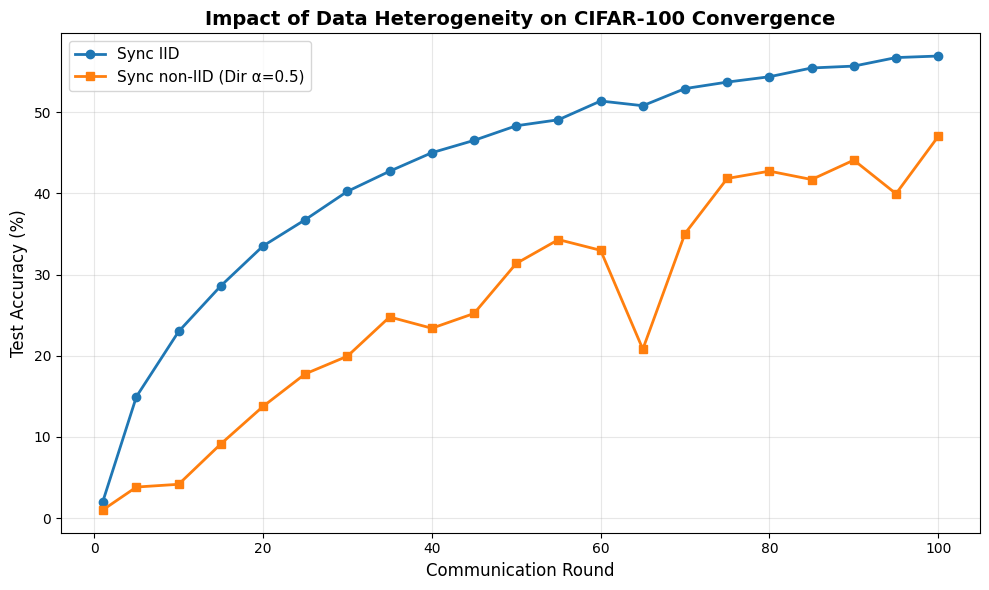

Final accuracy - Sync IID: 56.92%
Final accuracy - Sync non-IID: 47.02%


In [20]:

# Plot 1: Impact of data heterogeneity (Sync only)
plt.figure(figsize=(10, 6))
plt.plot(history_sync_iid['rounds'], history_sync_iid['test_acc'],
         marker='o', linewidth=2, label='Sync IID')
plt.plot(history_sync_noniid['rounds'], history_sync_noniid['test_acc'],
         marker='s', linewidth=2, label='Sync non-IID (Dir α=0.5)')
plt.xlabel('Communication Round', fontsize=12)
plt.ylabel('Test Accuracy (%)', fontsize=12)
plt.title('Impact of Data Heterogeneity on CIFAR-100 Convergence', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final accuracy - Sync IID: {history_sync_iid['test_acc'][-1]:.2f}%")
print(f"Final accuracy - Sync non-IID: {history_sync_noniid['test_acc'][-1]:.2f}%")


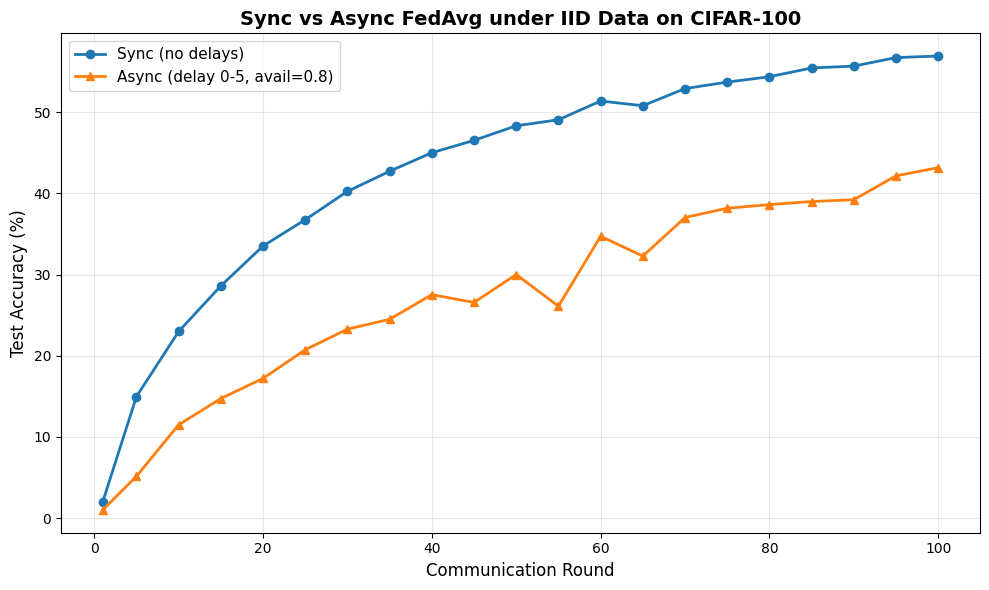

Final accuracy - Sync: 56.92%
Final accuracy - Async: 43.17%


In [21]:

# Plot 2: Sync vs Async under IID data
plt.figure(figsize=(10, 6))
plt.plot(history_sync_iid['rounds'], history_sync_iid['test_acc'],
         marker='o', linewidth=2, label='Sync (no delays)')
plt.plot(history_async_iid['rounds'], history_async_iid['test_acc'],
         marker='^', linewidth=2, label='Async (delay 0-5, avail=0.8)')
plt.xlabel('Communication Round', fontsize=12)
plt.ylabel('Test Accuracy (%)', fontsize=12)
plt.title('Sync vs Async FedAvg under IID Data on CIFAR-100', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final accuracy - Sync: {history_sync_iid['test_acc'][-1]:.2f}%")
print(f"Final accuracy - Async: {history_async_iid['test_acc'][-1]:.2f}%")


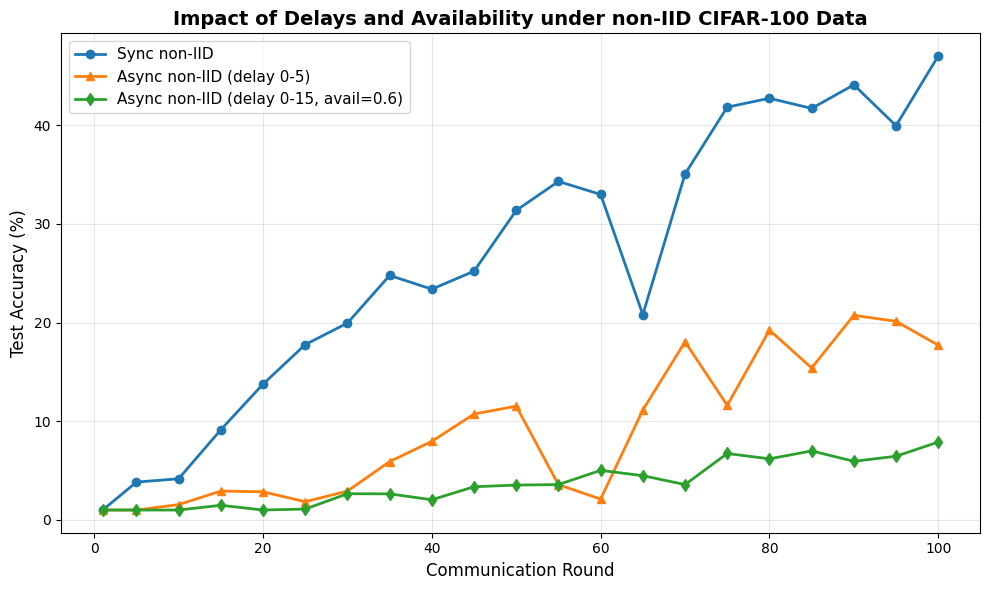

Final accuracy - Sync: 47.02%
Final accuracy - Async moderate: 17.71%
Final accuracy - Async heavy: 7.89%


In [22]:

# Plot 3: Sync vs Async under non-IID data
plt.figure(figsize=(10, 6))
plt.plot(history_sync_noniid['rounds'], history_sync_noniid['test_acc'],
         marker='o', linewidth=2, label='Sync non-IID')
plt.plot(history_async_noniid['rounds'], history_async_noniid['test_acc'],
         marker='^', linewidth=2, label='Async non-IID (delay 0-5)')
plt.plot(history_async_heavy['rounds'], history_async_heavy['test_acc'],
         marker='d', linewidth=2, label='Async non-IID (delay 0-15, avail=0.6)')
plt.xlabel('Communication Round', fontsize=12)
plt.ylabel('Test Accuracy (%)', fontsize=12)
plt.title('Impact of Delays and Availability under non-IID CIFAR-100 Data', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final accuracy - Sync: {history_sync_noniid['test_acc'][-1]:.2f}%")
print(f"Final accuracy - Async moderate: {history_async_noniid['test_acc'][-1]:.2f}%")
print(f"Final accuracy - Async heavy: {history_async_heavy['test_acc'][-1]:.2f}%")


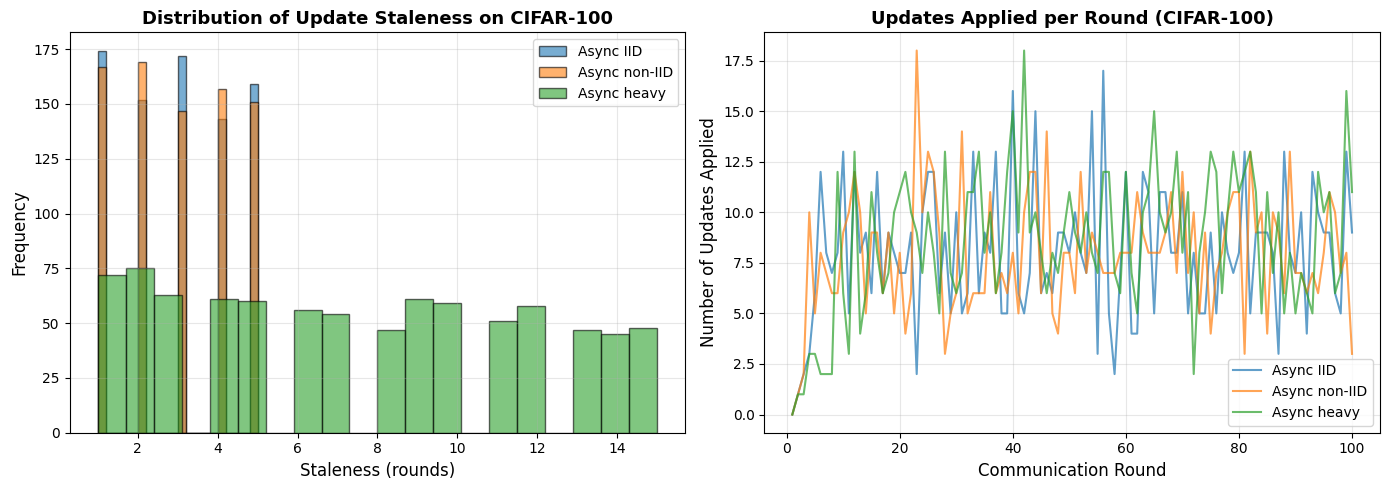

Async IID staleness:
  Mean: 2.95
  Std: 1.43
  Max: 5
Async non-IID staleness:
  Mean: 2.94
  Std: 1.42
  Max: 5
Async heavy staleness:
  Mean: 7.47
  Std: 4.35
  Max: 15


In [23]:

# Plot 4: Staleness analysis for async runs
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of staleness
axes[0].hist(history_async_iid['staleness'], bins=20, alpha=0.6, label='Async IID', edgecolor='black')
axes[0].hist(history_async_noniid['staleness'], bins=20, alpha=0.6, label='Async non-IID', edgecolor='black')
axes[0].hist(history_async_heavy['staleness'], bins=20, alpha=0.6, label='Async heavy', edgecolor='black')
axes[0].set_xlabel('Staleness (rounds)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Update Staleness on CIFAR-100', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Updates per round
rounds_plot = range(1, len(history_async_iid['num_updates_per_round']) + 1)
axes[1].plot(rounds_plot, history_async_iid['num_updates_per_round'],
             alpha=0.7, linewidth=1.5, label='Async IID')
axes[1].plot(rounds_plot, history_async_noniid['num_updates_per_round'],
             alpha=0.7, linewidth=1.5, label='Async non-IID')
axes[1].plot(rounds_plot, history_async_heavy['num_updates_per_round'],
             alpha=0.7, linewidth=1.5, label='Async heavy')
axes[1].set_xlabel('Communication Round', fontsize=12)
axes[1].set_ylabel('Number of Updates Applied', fontsize=12)
axes[1].set_title('Updates Applied per Round (CIFAR-100)', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print staleness statistics
for name, hist in [('Async IID', history_async_iid),
                   ('Async non-IID', history_async_noniid),
                   ('Async heavy', history_async_heavy)]:
    if len(hist['staleness']) > 0:
        print(f"{name} staleness:")
        print(f"  Mean: {np.mean(hist['staleness']):.2f}")
        print(f"  Std: {np.std(hist['staleness']):.2f}")
        print(f"  Max: {np.max(hist['staleness'])}")


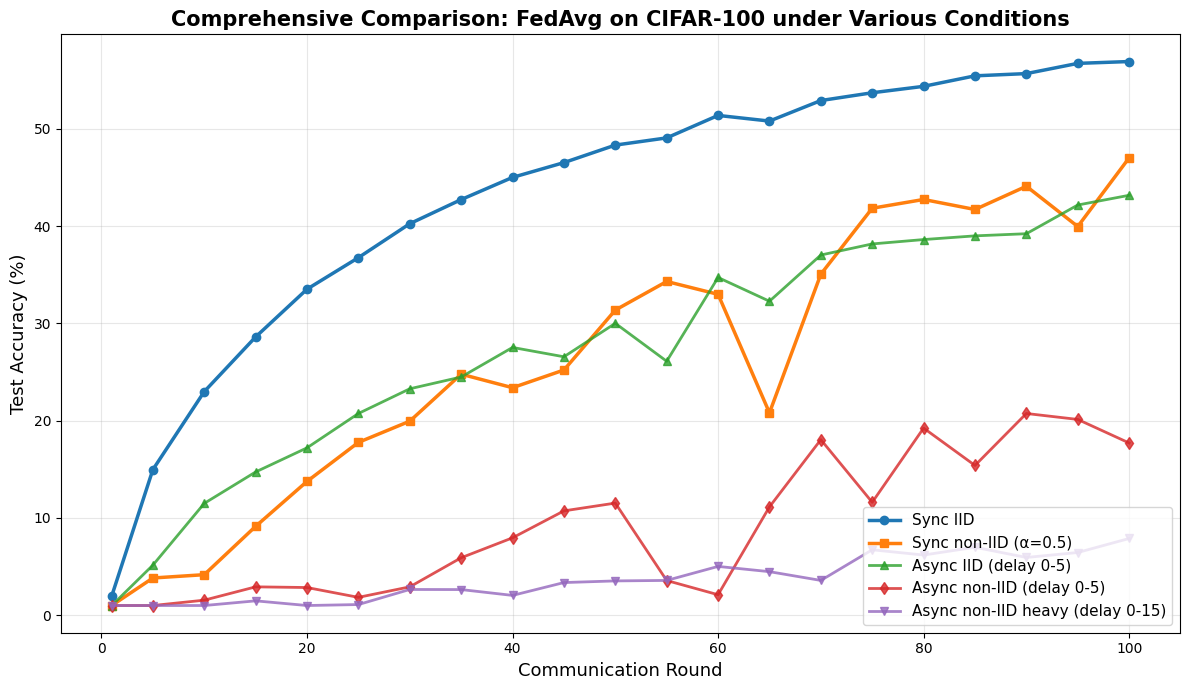

In [24]:

# Comprehensive comparison plot
plt.figure(figsize=(12, 7))

plt.plot(history_sync_iid['rounds'], history_sync_iid['test_acc'],
         marker='o', linewidth=2.5, markersize=6, label='Sync IID')
plt.plot(history_sync_noniid['rounds'], history_sync_noniid['test_acc'],
         marker='s', linewidth=2.5, markersize=6, label='Sync non-IID (α=0.5)')
plt.plot(history_async_iid['rounds'], history_async_iid['test_acc'],
         marker='^', linewidth=2, markersize=6, alpha=0.8, label='Async IID (delay 0-5)')
plt.plot(history_async_noniid['rounds'], history_async_noniid['test_acc'],
         marker='d', linewidth=2, markersize=6, alpha=0.8, label='Async non-IID (delay 0-5)')
plt.plot(history_async_heavy['rounds'], history_async_heavy['test_acc'],
         marker='v', linewidth=2, markersize=6, alpha=0.8, label='Async non-IID heavy (delay 0-15)')

plt.xlabel('Communication Round', fontsize=13)
plt.ylabel('Test Accuracy (%)', fontsize=13)
plt.title('Comprehensive Comparison: FedAvg on CIFAR-100 under Various Conditions', fontsize=15, fontweight='bold')
plt.legend(fontsize=11, loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
